# Trabalho 3 de Aprendizado de Máquina

Trabalho sobre Classificadores.

- **Aluna:** Bárbara Neves
- **Matrícula:** 388713

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importando os módulos das implementações feitas
from modules import models, utils

## Implementação

Foram criados 2 módulos (arquivos *``` .py ```*) para guardar as implementações solicitadas, além de outras funções criadas com o intuito de ajudar nas análises feitas neste trabalho. 

Os arquivos estão na pasta ``` modules/ ```. A seguir, estão os nomes e a descrição de cada um.
 
- **``` models ```:** contém as implementações da rede neural ***Multilayer Perceptron* (MLP)** para classificação e do método ***K-Nearest Neighbors* (K-NN)**.
- **``` utils ```:** contém as implementações da função de acurácia, e os métodos ```plot_confusion_matrix``` e ```plot_boundaries```, feitas para o Trabalho 2, junto com a função ```k_fold``` e outras funções necessárias para este trabalho.

O import desses arquivos foi feito acima a partir do seguinte comando: ``` from modules import models, utils ```

## Conjunto de dados
### 1. Leitura do conjunto de dados: ``` data_trab3 ```

In [2]:
df = pd.DataFrame(columns=['X_0', 'X_1', 'y'])

with open('data_trab3/data1.txt', 'r') as f: 
    for line in f:
        try:
            line = float(line)
        except ValueError:
            pass
        split_line = line.split(',')
        df = df.append({
            'X_0': float(split_line[0]),
            'X_1': float(split_line[1]),
            'y': float(split_line[2])
        }, ignore_index=True)
        
df.head()

,X_0,X_1,y
0,34.623660,78.024693,0.0
1,30.286711,43.894998,0.0
2,35.847409,72.902198,0.0
3,60.182599,86.308552,1.0
4,79.032736,75.344376,1.0


### 2. X e y

A duas primeiras colunas são as características (X) e a última coluna é a variável alvo (y).

In [3]:
X = df.values[:, :-1]
y = df.values[:, -1]

X.shape, y.shape

((100, 2), (100,))

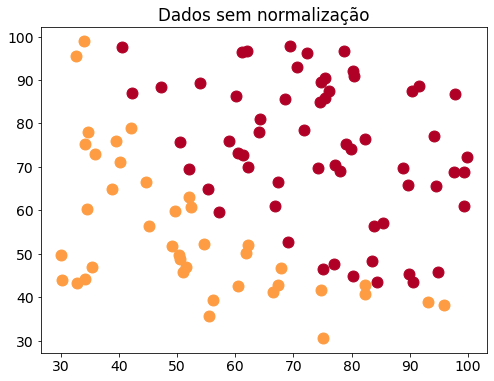

In [4]:
utils.plot_data(X, y, title='Dados sem normalização') 

## Relatório

### 1. Executar cada um dos métodos 

- K-NN, com k = 1, 2 e 3 
- MLP, com número de neurônios (*units*) = 2, 3 e 4

#### Normalização dos dados

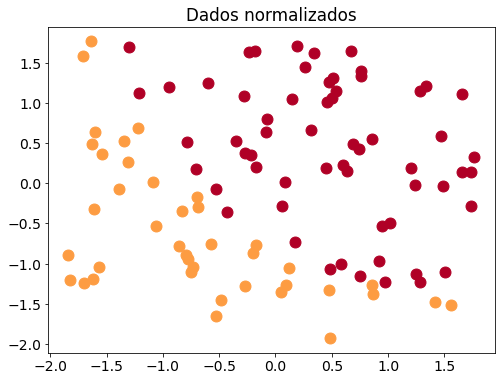

In [5]:
scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

utils.plot_data(X, y, title='Dados normalizados')

#### Escolhendo a melhor quantidade de épocas e valor para a taxa de aprendizado (α) para a MLP

*Loss function:* função logística.

[MLP] Melhor modelo encontrado: alpha=0.01


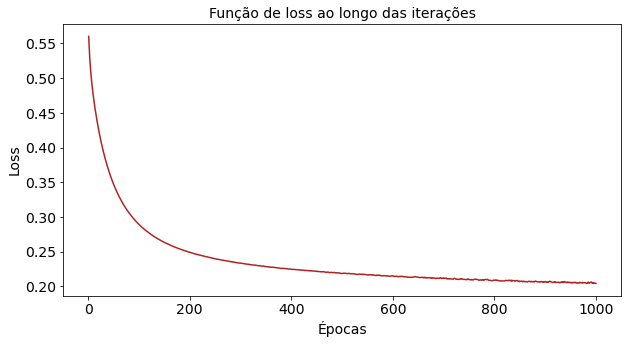

In [6]:
np.seterr(divide='ignore', invalid='ignore', over='ignore')

# Separando em treino e teste apenas para avaliação do melhor alpha e da melhor quantidade de épocas
# Esses conjuntos também serão usados mais adiante para as matrizes de confusão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Tamanho da camada oculta = 4 
best_alpha = utils.grid_search_mlp(X_train, X_test, y_train, y_test, 4, 1000)

### a. O erro do 5-fold

In [7]:
cv = 5
epochs = 100

KNN_dict = {k: utils.k_fold(X, y, cv, models.KNeighborsClassifier(n_neighbors=k)) for k in range(1, 4)}
MLP_dict = {k: utils.k_fold(X, y, cv, models.MLPClassifier(hidden_unit=k, epochs=epochs, alpha=best_alpha)) for k in range(2, 5)}

#### MLP

In [8]:
print('[MLP] Erro do 5-fold:')
for k, v in MLP_dict.items():
    print('units={} -> error={}'.format(k, v))

[MLP] Erro do 5-fold:
units=2 -> error=0.9
units=3 -> error=0.8666666666666668
units=4 -> error=0.8666666666666668


#### K-NN

In [9]:
print('[K-NN] Erro do 5-fold:')
for k, v in KNN_dict.items():
    print('k={} -> error={}'.format(k, v))

[K-NN] Erro do 5-fold:
k=1 -> error=0.9
k=2 -> error=0.8666666666666666
k=3 -> error=0.8333333333333333


### b. Gráficos de dispersão 

- As fronteiras de separação são produzidas com os métodos treinados com todo o conjunto de dados.
- Os métodos recebem como hiper-parâmetro (valor do *k* para o K-NN e quantidade de neurônios para a MLP) o que obteve o maior valor de acurácia na execução do 5-*fold*.

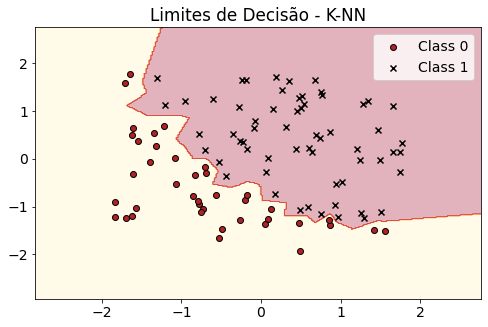

In [10]:
KNN = models.KNeighborsClassifier(n_neighbors=max(KNN_dict, key=KNN_dict.get))
KNN.fit(X, y)

utils.plot_boundaries(X, y, KNN, title='Limites de Decisão - K-NN')

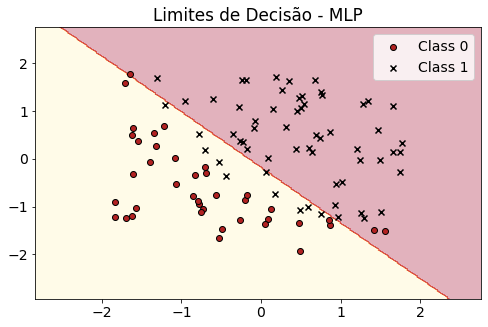

In [11]:
MLP = models.MLPClassifier(hidden_unit=max(MLP_dict, key=MLP_dict.get), epochs=epochs, alpha=best_alpha)
MLP.fit(X, y)

utils.plot_boundaries(X, y, MLP, title='Limites de Decisão - MLP')

### Matrizes de confusão

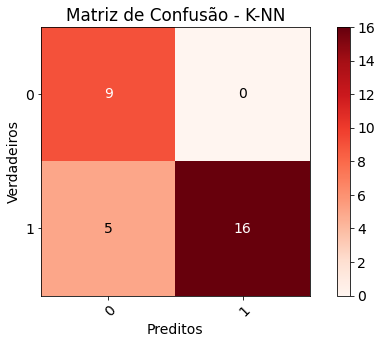

In [12]:
KNN.fit(X_train, y_train)
y_pred_knn = KNN.predict(X_test)

utils.plot_confusion_matrix(y_test, y_pred_knn, title='Matriz de Confusão - K-NN');

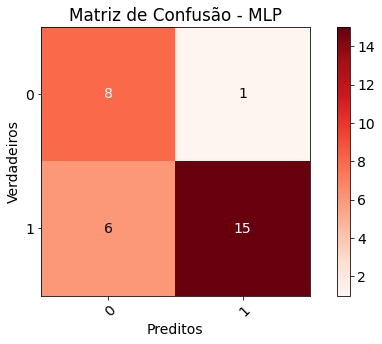

In [13]:
MLP.fit(X_train, y_train)
y_pred_mlp = MLP.predict(X_test)

utils.plot_confusion_matrix(y_test, y_pred_mlp, title='Matriz de Confusão - MLP');

### Conclusões

1. De acordo com os gráficos de dispersão, a fronteira de separação traçada pelo K-NN foi bem precisa. No entanto, a MLP acabou entendendo os dados como um problema linear. 
2. As matrizes de confusão do K-NN e da MLP não estão tão diferentes. A da K-NN está bem melhor, claro, dado que este modelo errou apenas na predição da classe 0 (número de falsos negativos = 5). A MLP errou 5 vezes a classe 0 e uma vez a classe 1, achando que seria 0 (número de falsos negativos = 6; número de falsos positivos = 1).
3. Se a minha implementação da MLP estiver mais ou menos correta, creio que o método K-NN se saiu melhor porque a distribuição dos dados é bem definida e tem um comportamento um pouco linear. Como esses dados não são tão complexos assim, a MLP não obteve um bom desempenho.